## Table of Content

- [1.0 - Packages](#1.0)
- [2.0 - Data Pre-processing](#2.0)
    - [2.1 - One-Hot Encoding](#2-1)
    - [2.2 - Visualize Training Dataset](#2-2)
    - [2.3 - Visualize Image Augmentation](#2-3)
- [3.0 - Model Configuration](#3.0)
    - [3.1 - Model Architecture](#3-1)
    - [3.2 - Loss Function and Metric](#3-2)
- [4.0 - Training](#4.0)
- [5.0 - Evaluation and Analysis](#5.0)
    - [5.1 - Visualize Test Set](#5-1)
    - [5.2 - Create Predictions](#5-2)
    - [5.3 - Visualize Predictions](#5-3)
    - [5.4 - Evaluation](#5-4)
- [6.0 - Conclusion and Recommendation](#6.0)

This is part two of the Image segmentation notebook. For dataset analysis and objective of the project, please take a look at the first part of the series, titled <b>fashion_images_eda.ipynb</b>

<a name='1.0'></a>

#### 1.0 PACKAGES

In [1]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

from utils_test import visualize, one_hot_encode, reverse_one_hot, color_code_segmentation, get_training_augmentation, get_validation_augmentation, to_tensor, get_preprocessing, visualize_norm

<a name='2.0'></a>

#### 2.0 DATA PRE-PROCESSING

In [14]:
DATA_DIR = 'archive'
metadata_df = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))
metadata_df = metadata_df[['image_path', 'label_type', 'label_path']]
metadata_df['image_path'] = metadata_df['image_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
metadata_df['label_path'] = metadata_df['label_path'].apply(lambda lbl_pth: os.path.join(DATA_DIR, 'labels', lbl_pth))

# select data subset with pixel-level annotations (ignoring image-level annotations)
metadata_df = metadata_df[metadata_df['label_type']=='pixel-level']

# Shuffle DataFrame
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

# Perform 80/10/10 split for train/val/test
valid_df = metadata_df.sample(frac=0.2, random_state=42)
train_df = metadata_df.drop(valid_df.index)
test_df = valid_df.sample(frac=0.5, random_state=42)
valid_df = valid_df.drop(test_df.index)
len(train_df), len(valid_df), len(test_df)

(803, 101, 100)

In [15]:
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))

# Get class names
class_names = class_dict['class_name'].tolist()

# Re-writing 'null' class to prevent a NaN value
class_names[0] = 'null'

# Get class RGB values
class_rgb_values = class_dict[['r', 'g', 'b']].values.tolist()

In [16]:
# Get RGB values of required classes
class_indices = [class_names.index(cls.lower()) for cls in class_names]
class_rgb_values = np.array(class_rgb_values)[class_indices]

In [ ]:
class_rgb_values

<a name='2-1'></a>

##### 2.1 One Hot Encoding

For the purpose of this project, one-hot encoding will be employed to encode the ground truth masks. One-hot encoding is an encoding method used in semantic image segmentation, which transforms pixel-wise class labels into a format that is compatible with the neural network architecture.

Each pixel in the ground truth mask is assigned a one-hot vectorm which is a binary vector with a length equal to the number of classes. This vector represents the presence or abscene of each class at that pixel location, effectively converting the segmentation task into a pixel-wise classification problem.

Take a look at the image below for a visualization example of the one-hot encoding process on a classification of an image with 4 available classes:
(image from <a href="https://www.v7labs.com/blog/image-segmentation-guide#h5" target="_blank">v7labs</a>)

<figure>
    <center><img src="./images/config_images/one-hot-encode.png"   style="width:400px;height:650px;" ></center>
</figure>

In [5]:
class ClothesDataset(torch.utils.data.Dataset):
    """
    Clothes co-parsing dataset. read images, apply augmentation and preprocessing transformations.
    Args:
        df(str): DataFrame containing images/labels paths
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transformation pipeline.
            e.g., flip, scale, etc
        preprocessing (albumentations.Compose): data preprocessing
            e.g., normalization, shape manipulation, etc.
    """
    def __init__(
        self,
        df,
        class_rgb_values=None,
        augmentation=None,
        preprocessing=None
    ):
        self.image_paths = df['image_path'].tolist()
        self.mask_paths = df['label_path'].tolist()
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        # read images and masks
        image = cv2.imread(self.image_paths[i])[:,:,::-1]
        mask = cv2.imread(self.mask_paths[i])[:,:,::-1]

        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        # return length of
        return len(self.image_paths)

<a name='2-2'></a>

##### 2.2 Visualize Training Dataset

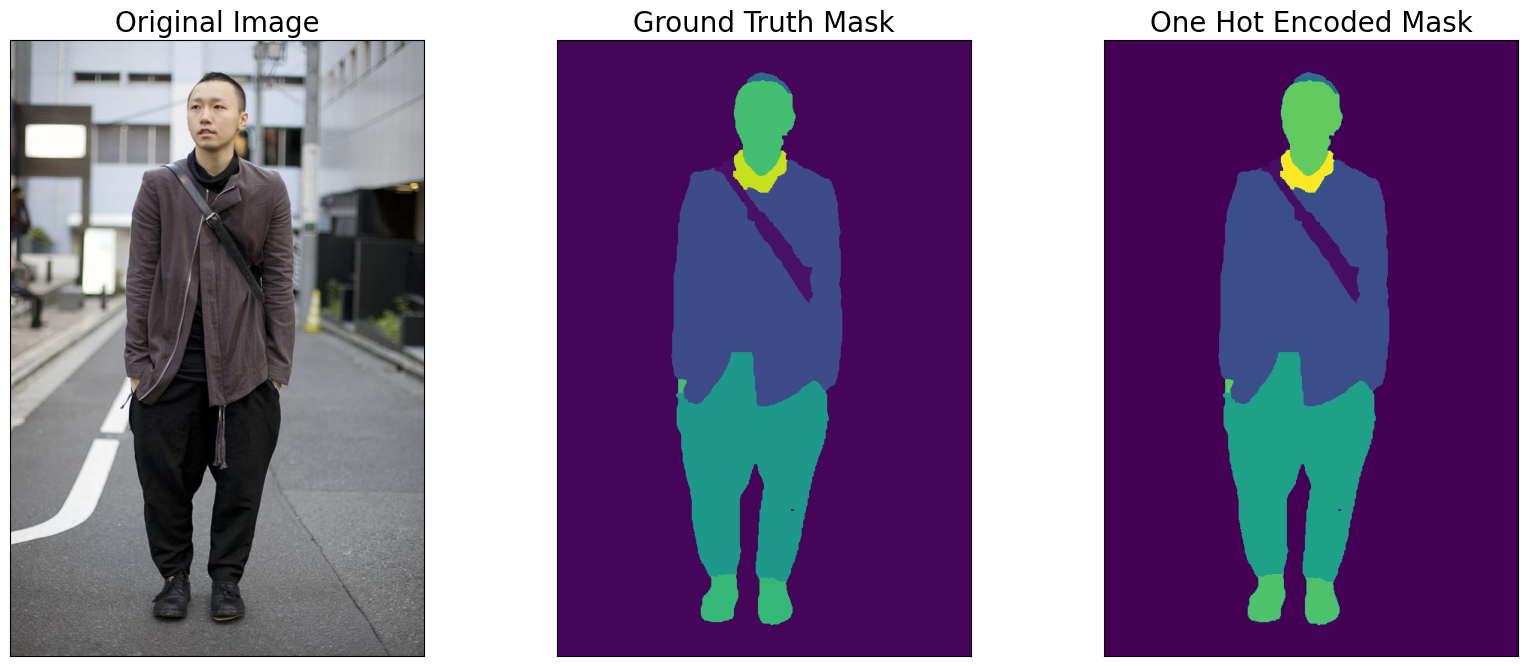

In [6]:
dataset = ClothesDataset(train_df, class_rgb_values=class_rgb_values)
random_idx = random.randint(0, len(dataset) - 1)
image, mask = dataset[random_idx]

visualize_norm(
    original_image = image,
    ground_truth_mask = color_code_segmentation(reverse_one_hot(mask), class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

<a name='2-3'></a>

##### 2.3 Visual Image Augmentation

The augmentations done to the dataset is zooming in and out images by 50% with a probability of 0.5 for each image and also horizontal and vertical flipping. These are selected randomly, let's take a look at a few examples.

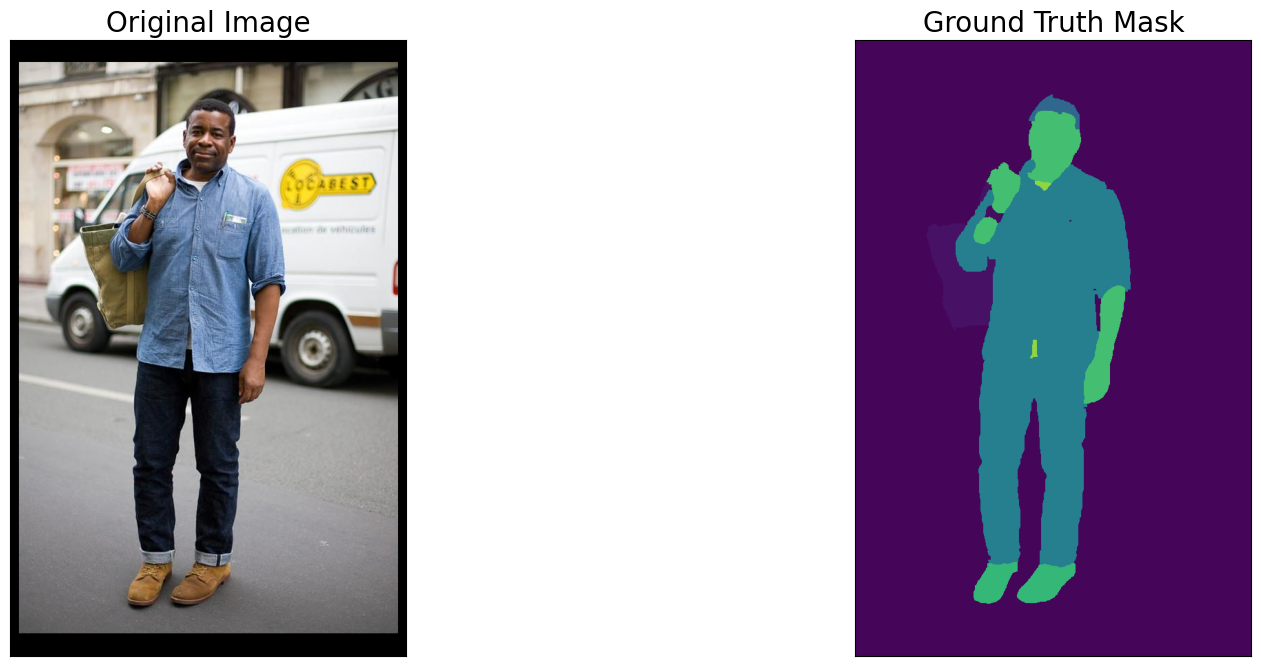

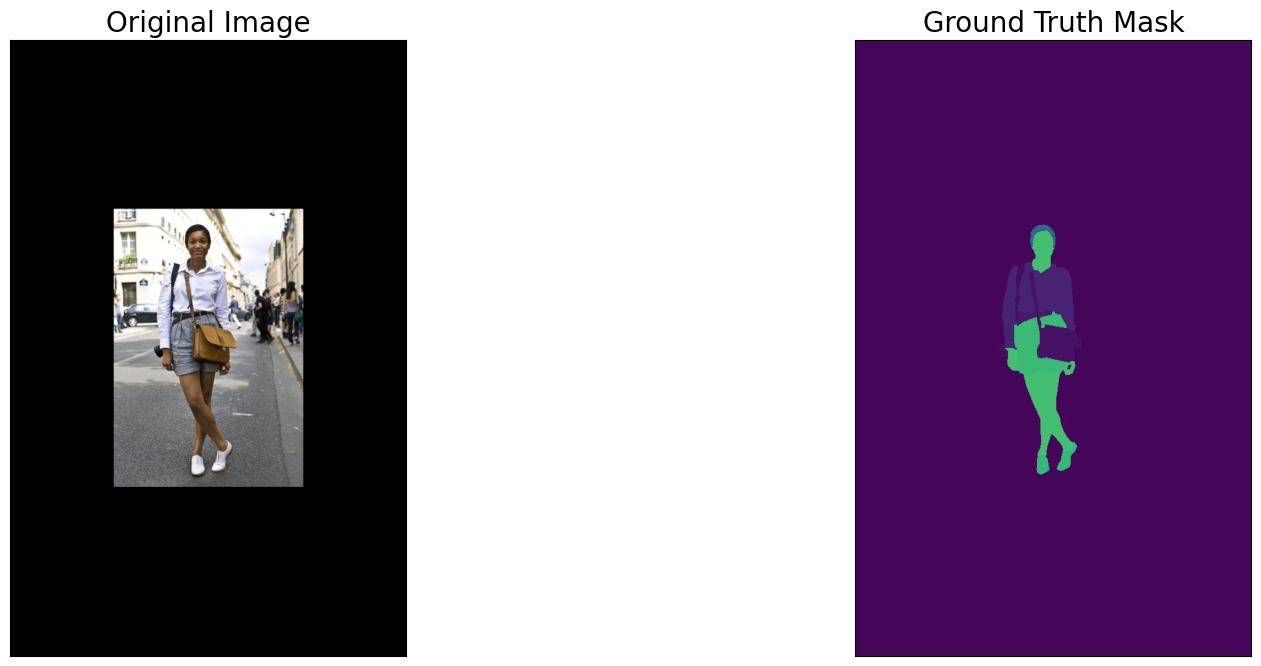

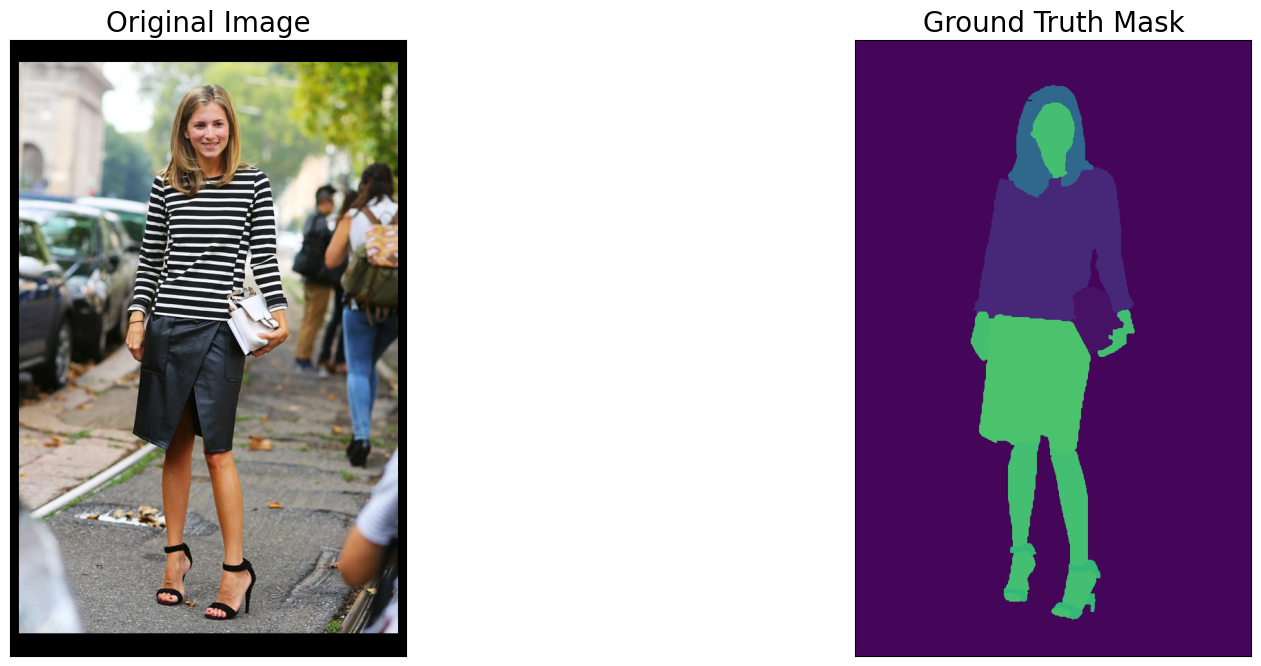

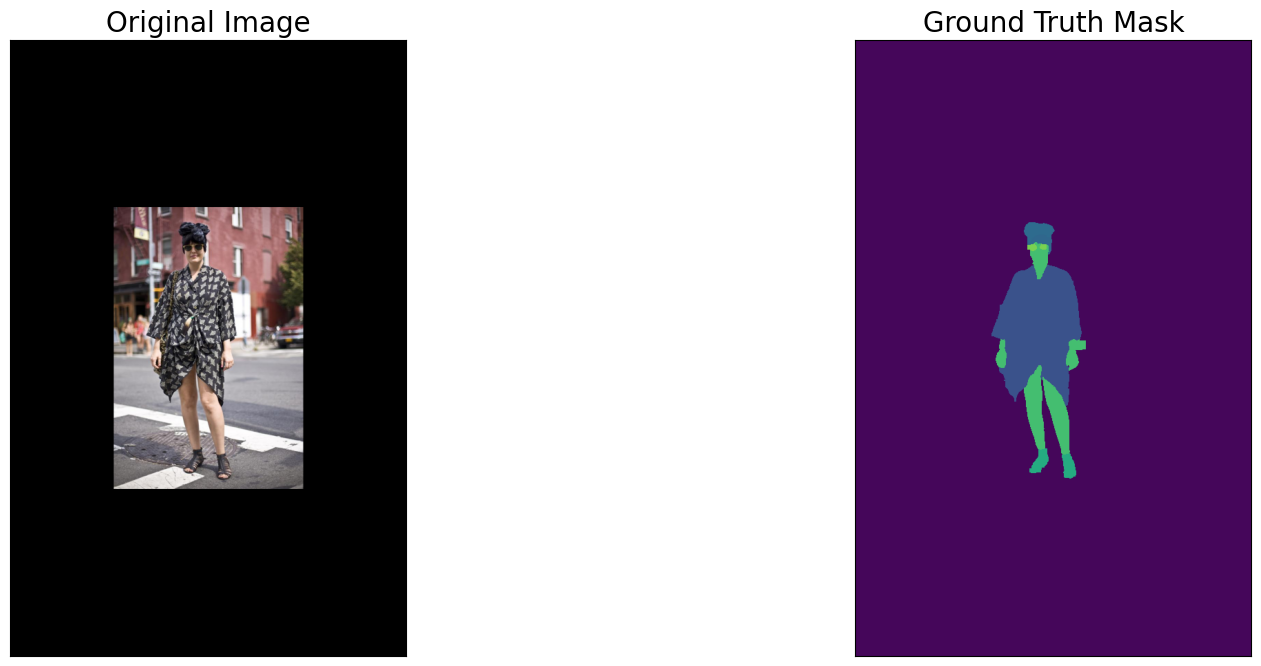

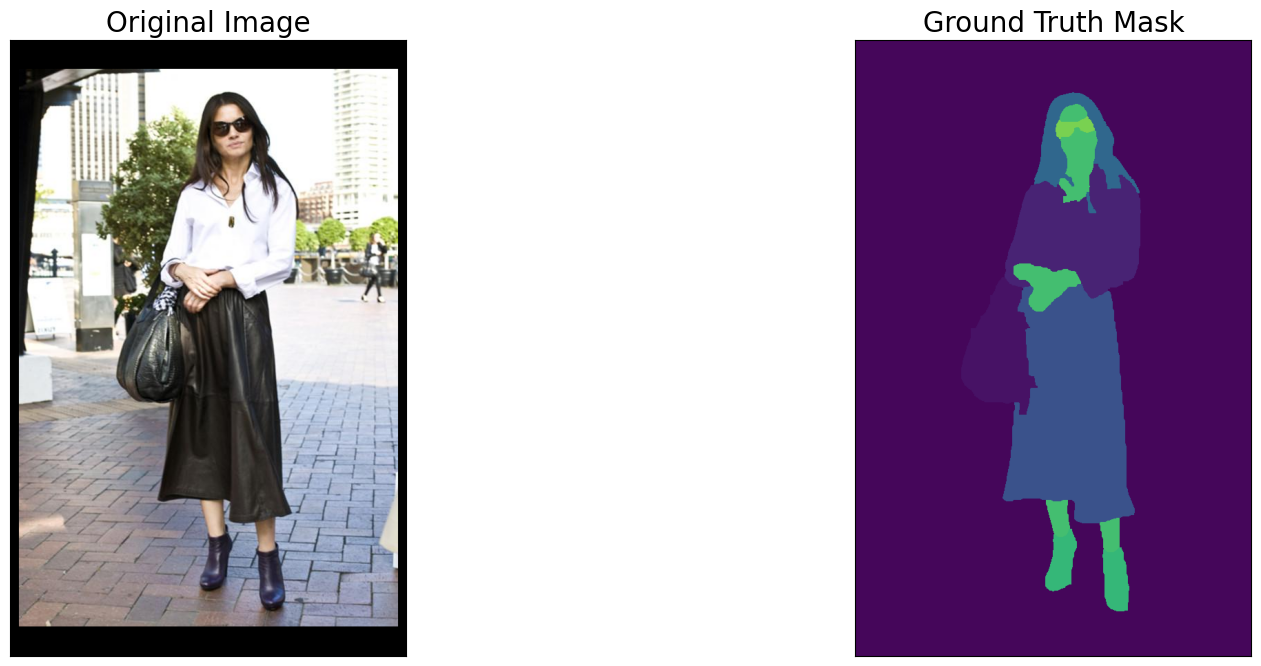

In [6]:
augmented_dataset = ClothesDataset(train_df,
                                   augmentation = get_training_augmentation(),
                                   class_rgb_values = class_rgb_values)

random_idx = random.randint(0, len(augmented_dataset) - 1)

# Different augmentations on image/mask pairs
for idx in range(5):
    image, mask = augmented_dataset[idx]
    visualize_norm(original_image = image,
              ground_truth_mask = color_code_segmentation(reverse_one_hot(mask), class_rgb_values))

<a name='3.0'></a>

#### 3.0 Model Configuration

<a name='3-1'></a>

##### 3.1 Model Architecture
The purpose of this project is to segment different categories for each class in an image to extract individual class features of the image for further processing. With that in mind, I would categorize it as a semantic image segmentation task. It's similar to object detection in that both ask the question: "What objects are in this image and where in the image are those objects located?," but where object detection labels objects with bounding boxes that may include pixels that aren't part of the object, semantic image segmentation allows the model to predict a precise mask for each object in the image by labeling each pixel.

For this project, I will be using U-Net, a type of CNN designed for quick, precise image segmentation, and using it to predict a label for every single pixel in an image.
U-Net has gained widespread recognition for its performance in semantic image segmentation tasks. Its effectiveness in accurately delineating object boundaries and producing precise masks aligns perfectly with the project's objective of segmenting multiple fashion classes within an image.

Take a look at the figure below as an example of how a U-Net architecture will take in a 128x128 image to learn about its features to segment each pixel into its classes.

(image from <a href="https://www.coursera.org/learn/convolutional-neural-networks/programming/omqTR/image-segmentation-with-u-net" target="_blank">DeepLearning.ai</a>)

<figure>
    <center><img src="./images/config_images/unet.png"   style="width:800px;height:500px;" ></center>
</figure>

U-Net's architecture, characterized by its distinctive U-shape, builds upon the Fully Convolutional Network (FCN) framework. FCN replaces the dense layers of traditional CNNs with transposed convolution layers, allowing for feature map upsampling while preserving spatial information. This spatial information is vital for image segmentation tasks, as it dictates "where" each object lies within the image. U-Net follows a similar design philosophy but takes it a step further. Instead of a single transposed convolution layer at the end, U-Net employs a symmetrical structure with a matching number of convolution and transposed convolution layers for both downsampling and upsampling. This symmetric design, along with the incorporation of skip connections, plays a crucial role in retaining fine-grained information and preventing information loss during encoding and decoding. These features make U-Net well-suited for multi-label segmentation task, ensuring that even intricate fashion details are accurately captured.

I will also be using ResNet-101 as the encoder network with pre-trained weights on ImageNet dataset. ResNet-101's depth and capacity enable it to capture high-level and abstraxt features from fashion images effectively. As encoder networks are responsible for feature extraction, ResNet-101's deep architecture can grasp intricate patterns and details in the images. This is especially relevant for fashion images, where clothing items may exhibit intricate designs and textures.

The selection of U-Net as the segmentation architcture and ResNet-101 as the encoder network is driven by their complementary strengths: U-Net's pixel-wise accuracy and boundary precision, and ResNet-101's ability to capture rich, high-level features.

<a name='3-2'></a>

##### 3.2 Loss Function and Metric

<b><u>Dice Loss</b></u>

I'll be using the <b>Dice Loss</b> for this segmentation task. It's derived from the Sørensen-Dice coefficient or F1 score, and it's suitable for multi-label segmentation tasks due to its ability to handle class imbalance.

Multi-label segmentation tasks often involve classes with varying pixel distributions, where some classes may be more prevalent than others in the dataset. The Dice loss naturally addresses this by focusing on the intersection between predicted and ground truth masks.

It also encourages precise pixel-wise predictions and quantifies the overlap between predicted and ground truth masks, effectively rewarding accurate delineation of object boundaries. This is crucial where fine-grained object detection is required.

The Dice Coefficient is defined as:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/a80a97215e1afc0b222e604af1b2099dc9363d3b)

To calculate the Loss, subtract the dice coefficient from 1, which will look like this:
Dice Loss = 1 - (2 * |X ∩ Y|) / (|X| + |Y|)

where X is the input/ground truth mask and Y is the predicted mask



<b><u>Jaccard Index/IoU Metric</b></u>

The IoU metric, or Jaccard Index, is similar to the Dice metric and is calculated as the ratio between the overlap of the positive instances between two sets, and their mutual combined values:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/eaef5aa86949f49e7dc6b9c8c3dd8b233332c9e7)

The IoU is a normalized version version of the Dice coefficient. Both metrics quantify the overlap between predicted and ground truth regions, with higher values indicating better segmentation performance. By minimizing the Dice Loss during training, the model can effectively maximize the IoU, as they are inversely related.

<a name='4.0'></a>

#### 4.0 TRAINING

In [14]:
from clothes_dataset import ClothesDataset
from segm_utils import visualize, one_hot_encode, reverse_one_hot, color_code_segmentation, get_training_augmentation, get_validation_augmentation, to_tensor, get_preprocessing
from torch.utils.data import DataLoader
import multiprocessing
import pickle

# Define the training function
def train_model():
    ENCODER = 'resnet101'
    ENCODER_WEIGHTS = 'imagenet'
    CLASSES = class_names
    ACTIVATION = 'sigmoid'

    # create a segmentation model with pretrained encoder
    model = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = ENCODER_WEIGHTS,
        classes = len(CLASSES),
        activation = ACTIVATION
    )

    preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

    # Set flag to train the model or not
    TRAINING = True

    # Set num of epochs
    EPOCHS = 10

    # Set device
    DEVICE = torch.device("mps")

    # Define loss function
    loss = smp.utils.losses.DiceLoss()

    # Define metrics
    metrics = [smp.utils.metrics.IoU(threshold=0.5)]

    # Define optimizer
    optimizer = torch.optim.Adam([
        dict(params=model.parameters(), lr=0.0002)
    ])

    # Load the best saved model checkpoint from previous commit
    if os.path.exists('./best_model.pth'):
        model = torch.load('./best_model.pth', map_location=DEVICE)

    # Get train and val dataset instances
    train_dataset = ClothesDataset(
        train_df,
        augmentation=get_training_augmentation(),
        preprocessing=get_preprocessing(preprocessing_fn),
        class_rgb_values=class_rgb_values
    )

    valid_dataset = ClothesDataset(
        valid_df,
        augmentation=get_validation_augmentation(),
        preprocessing=get_preprocessing(preprocessing_fn),
        class_rgb_values=class_rgb_values
    )

    train_epoch = smp.utils.train.TrainEpoch(
        model,
        loss=loss,
        metrics=metrics,
        optimizer=optimizer,
        device=DEVICE,
        verbose=True
    )

    valid_epoch = smp.utils.train.ValidEpoch(
        model,
        loss=loss,
        metrics=metrics,
        device=DEVICE,
        verbose=True
    )

    # Get train and validation data loaders
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=8,
                              multiprocessing_context="spawn",
                              persistent_workers=True)
    
    valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=8,
                              multiprocessing_context="spawn",
                              persistent_workers=True)
    
    # Training Loop
    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(1, EPOCHS + 1):
        # perform training and validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')

        # Save train and valid logs after each epoch
        with open('train_logs.pkl', 'wb') as f:
            pickle.dump(train_logs_list, f)
        with open('valid_logs.pkl', 'wb') as f:
            pickle.dump(valid_logs_list, f)

if __name__ == '__main__':
    # Call the training function
    train_model()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /Users/joankusuma/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:03<00:00, 56.1MB/s] 



Epoch: 1
valid: 100%|██████████| 26/26 [01:20<00:00,  3.09s/it, dice_loss - 0.8351, iou_score - 0.6369]
Model saved!

Epoch: 2
valid: 100%|██████████| 26/26 [00:53<00:00,  2.06s/it, dice_loss - 0.8363, iou_score - 0.6344]

Epoch: 3
valid: 100%|██████████| 26/26 [00:58<00:00,  2.26s/it, dice_loss - 0.8352, iou_score - 0.6383]
Model saved!

Epoch: 4
valid: 100%|██████████| 26/26 [00:53<00:00,  2.04s/it, dice_loss - 0.8352, iou_score - 0.634] 

Epoch: 5
valid: 100%|██████████| 26/26 [00:49<00:00,  1.91s/it, dice_loss - 0.8366, iou_score - 0.6355]

Epoch: 6
valid: 100%|██████████| 26/26 [00:51<00:00,  2.00s/it, dice_loss - 0.8363, iou_score - 0.6374]

Epoch: 7
valid: 100%|██████████| 26/26 [00:56<00:00,  2.18s/it, dice_loss - 0.8361, iou_score - 0.6371]

Epoch: 8
valid: 100%|██████████| 26/26 [00:57<00:00,  2.20s/it, dice_loss - 0.8359, iou_score - 0.6361]

Epoch: 9
valid: 100%|██████████| 26/26 [00:54<00:00,  2.10s/it, dice_loss - 0.8354, iou_score - 0.6377]

Epoch: 10
valid: 100%|██████

<a name='5.0'></a>

#### 5.0 EVALUATION AND ANALYSIS

In [8]:
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [9]:
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'sigmoid'

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [18]:
# load best saved model checkpoint from the current run
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=DEVICE)
    print('Loaded UNet model from this run.')

Loaded UNet model from this run.


<a name='5-1'></a>

##### 5.1 Visualize Test Set

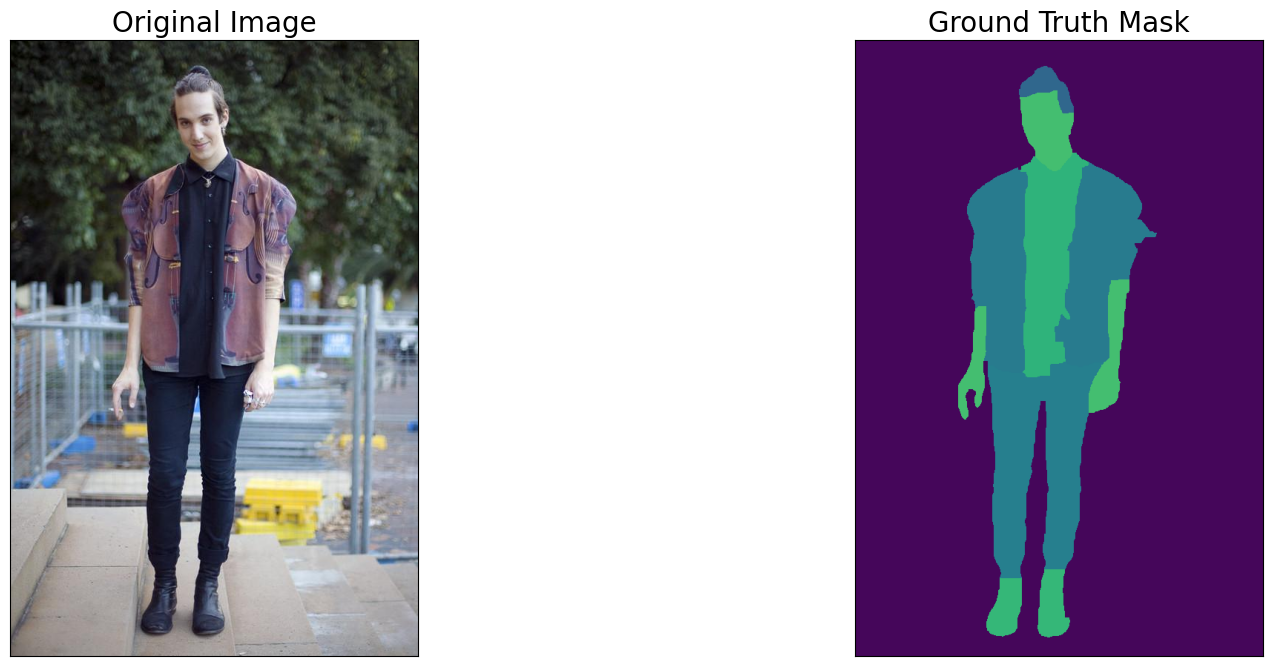

In [13]:
# Create test dataloader to be used with UNet model (with preprocessing operation: to_tensor(...))
test_dataset = ClothesDataset(
    test_df,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=class_rgb_values
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing augmentations and transformations)
test_dataset_vis = ClothesDataset(
    test_df,
    class_rgb_values=class_rgb_values
)

# get a random test image or mask index
random_idx = random.randint(0, len(test_dataset_vis) - 1)
image, mask = test_dataset_vis[random_idx]

visualize_norm(
    original_image = image,
    ground_truth_mask = color_code_segmentation(reverse_one_hot(mask), class_rgb_values)
)

<a name='5-2'></a>

##### 5.2 Create Predictions

In [20]:
# Center crop padded image or mask to original image dimensions
def crop_image(image, true_dimensions):
    return album.CenterCrop(p=1, height=true_dimensions[0],
                            width=true_dimensions[1])(image=image)

In [21]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [ ]:
for idx in range(5):
    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    true_dimensions = image_vis.shape
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

    # predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()

    # convert pred_mask from 'CHW' format to 'HWC' format
    pred_mask = np.transpose(pred_mask, (1, 2, 0))
    pred_mask = crop_image(color_code_segmentation(reverse_one_hot(pred_mask), class_rgb_values),
                           true_dimensions)['image']
    
    # convert gt_mask from 'CHW" format to 'HWC' format
    gt_mask = np.transpose(gt_mask, (1, 2, 0))
    gt_mask = crop_image(color_code_segmentation(reverse_one_hot(gt_mask), class_rgb_values),
                         true_dimensions)['image']
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"),
                np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    
    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask
    )

<a name='5-3'></a>

##### 5.3 Visualize Predictions

Let's take a look at a few mask predictions from this model. The model tend to generalize better to hair, skin, and background pixels. It's also able to generalize to dress and pants predictions, and the result seems to correlate to the class distribution in the EDA, where classes that's better represented tend to help the model learn that particular class's attributes better.

It does seem to learn better on classes that occupies more pixel areas as opposed to the number of times each class is represented in the dataset (take a look at the shoes vs dress predictions, even though shoes appears in 775 images, wherease dress only appears in 271 images in the dataset, but the dresses tend to occupy significantly more pixels per image compared to shoes), the model doesn't seem to generate any shoes prediction mask at all, but dress predictions appears in almost every prediction mask.

<figure>
    <center> <img src="./sample_predictions/sample_pred_0.png"   style="width:850px;height:400px;" ></center>
</figure>

<figure>
    <center> <img src="./sample_predictions/sample_pred_1.png"   style="width:850px;height:400px;" ></center>
</figure>

<figure>
    <center> <img src="./sample_predictions/sample_pred_2.png"   style="width:850px;height:400px;" ></center>
</figure>

<figure>
    <center> <img src="./sample_predictions/sample_pred_3.png"   style="width:850px;height:400px;" ></center>
</figure>

<figure>
    <center> <img src="./sample_predictions/sample_pred_4.png"   style="width:850px;height:400px;" ></center>
</figure>

<figure>
    <center> <img src="./sample_predictions/sample_pred_5.png"   style="width:850px;height:400px;" ></center>
</figure>

<figure>
    <center> <img src="./sample_predictions/sample_pred_6.png"   style="width:850px;height:400px;" ></center>
</figure>

<figure>
    <center> <img src="./sample_predictions/sample_pred_7.png"   style="width:850px;height:400px;" ></center>
</figure>

<figure>
    <center> <img src="./sample_predictions/sample_pred_8.png"   style="width:850px;height:400px;" ></center>
</figure>

<figure>
    <center> <img src="./sample_predictions/sample_pred_9.png"   style="width:850px;height:400px;" ></center>
</figure>

<a name='5-4'></a>

##### 5.4 Evaluation

The training and validation loss and metric values through the epochs provide valuable insights into the performance and training progress of the model. Let's take a look at a few plots, I plotted the first IoU score plot between 0-1 on the y-axis(vertical line), in which the plot shows that the model is converging.

Looking at the IoU score, which measures the overlap between predicted and ground truth masks, show promising results. The training IoU score varies between approximately 0.590 and 0.618, while the validation IoU score ranges from 0.633 to 0.638

Examining the Dice Loss, its values range from around 0.843 to 0.846 for training and 0.835 to 0.836 for validation. These also suggest that the model is achieving a good balance between true positives and false positives during segmentation.

Looking at both the loss and score through the plot though, they may appear relatively close to each other throughout the training process, but there is not significant improvement over the epochs. The consistency in performance metrics between training and validation sets suggests that the model may not be overfitting the training data, but it also indicates that the model might have reached a plateau and is not improving significantly.

In [18]:
import pickle
import pandas as pd

# Load train_logs_list and valid_logs_list from the file
with open('./model_logs/train_logs.pkl', 'rb') as f:
    train_logs_list = pickle.load(f)

with open('./model_logs/valid_logs.pkl', 'rb') as f:
    valid_logs_list = pickle.load(f)

# Now you can create DataFrames from these variables
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df = train_logs_df.T  # Transpose the DataFrame if needed
train_logs_df

,0,1,2,3,4,5,6,7,8,9
dice_loss,0.846540,0.844277,0.845402,0.845101,0.843328,0.845357,0.843833,0.846400,0.840930,0.844185
iou_score,0.592493,0.603579,0.590846,0.598916,0.606301,0.594810,0.599091,0.597735,0.618309,0.602557


In [19]:
valid_logs_df = valid_logs_df.T
valid_logs_df

,0,1,2,3,4,5,6,7,8,9
dice_loss,0.835140,0.836306,0.835155,0.835224,0.836625,0.836342,0.836131,0.835904,0.835419,0.836112
iou_score,0.636895,0.634414,0.638349,0.633964,0.635474,0.637353,0.637104,0.636129,0.637704,0.636053


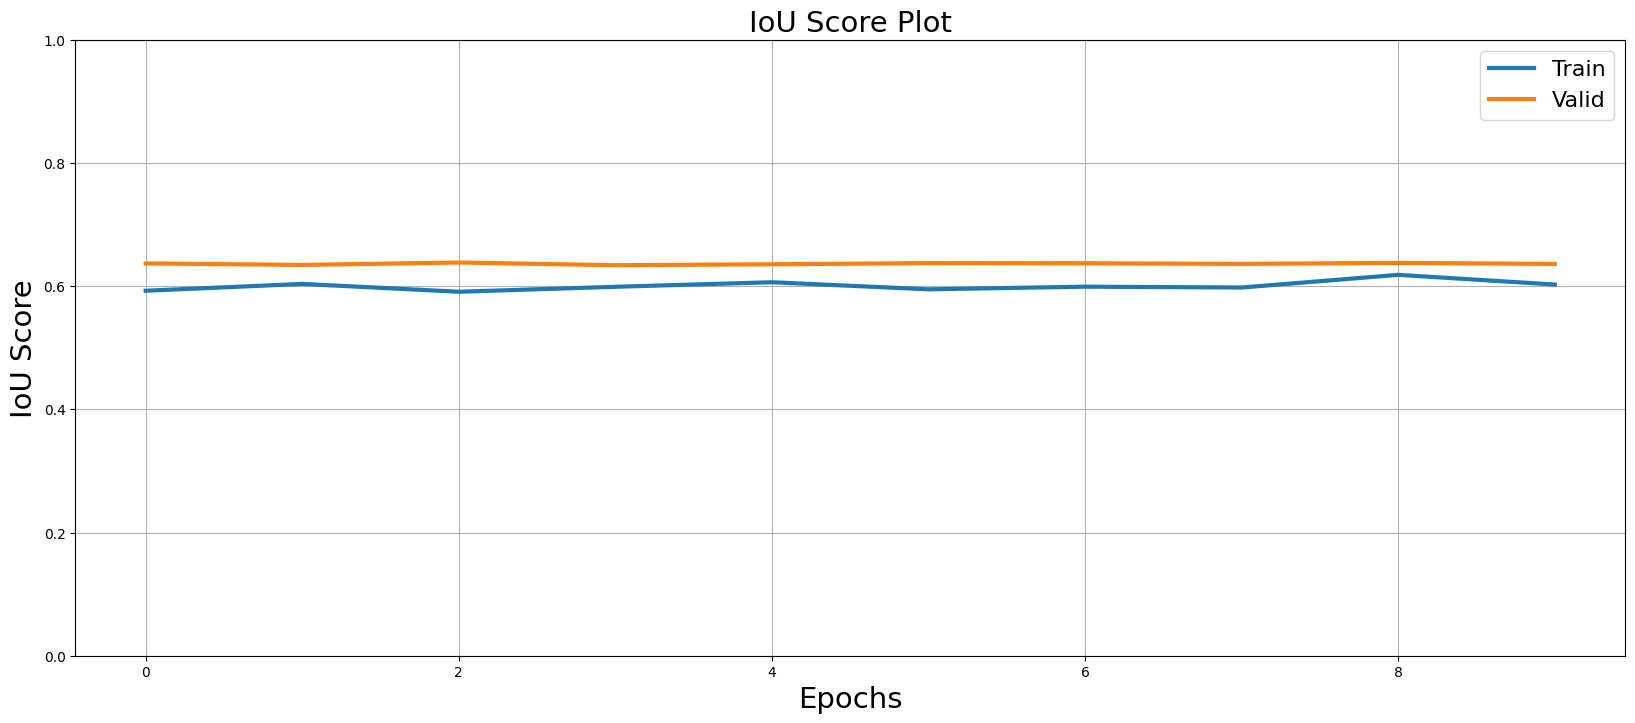

In [20]:
import matplotlib.pyplot as plt

# Extract the second row (third row including header) as x-axis values
x_values = range(len(train_logs_df.columns))

# Assuming 'iou_score' is the column name
plt.figure(figsize=(20, 8))
plt.plot(x_values, train_logs_df.iloc[1], lw=3, label='Train')  # Using iloc[1] to access the second row
plt.plot(x_values, valid_logs_df.iloc[1], lw=3, label='Valid')  # Using iloc[1] to access the second row
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('IoU Score', fontsize=21)
plt.title('IoU Score Plot', fontsize=21)

# Set the y-axis limits to range from 0 to 1
plt.ylim(0, 1)

plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

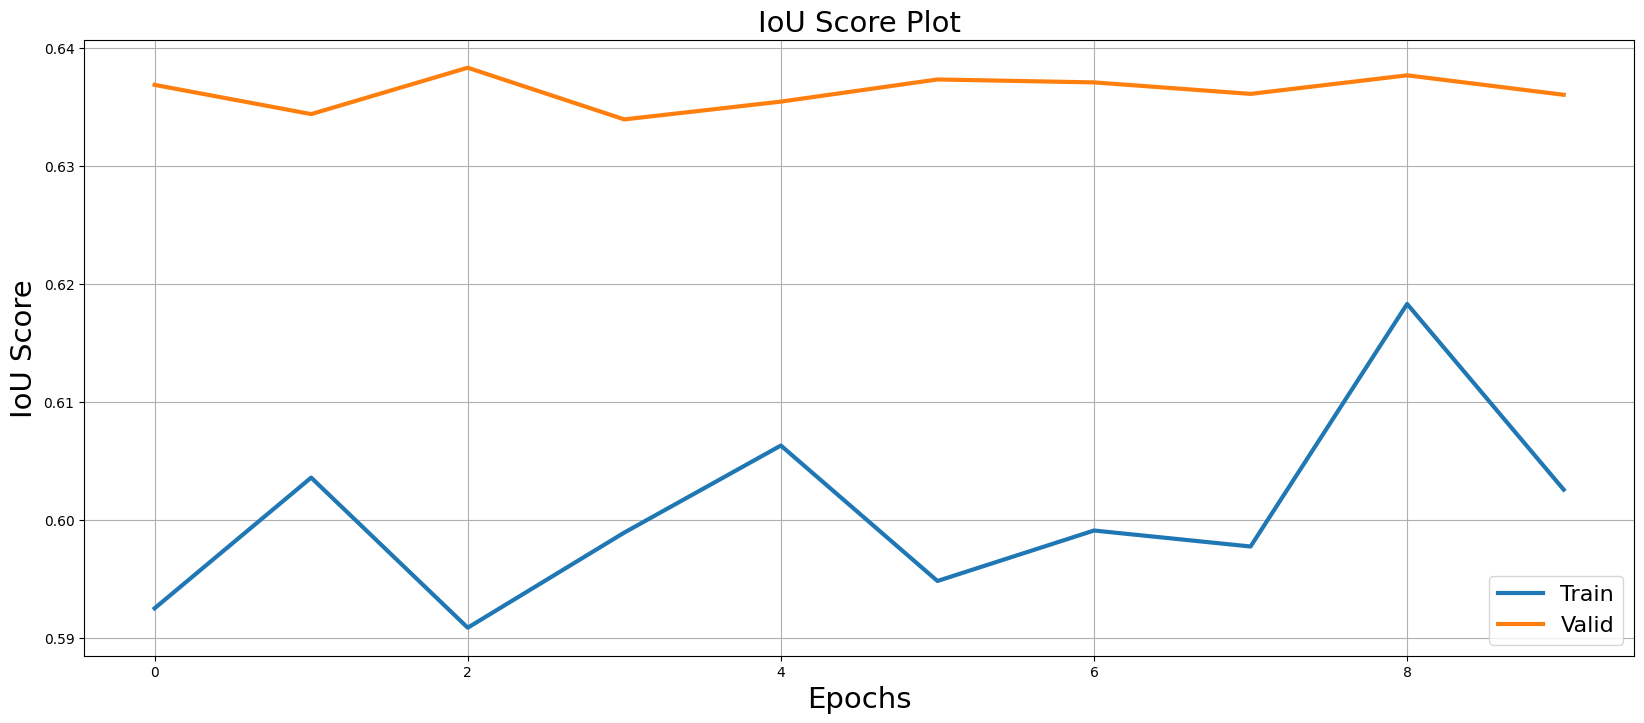

In [25]:
import matplotlib.pyplot as plt

# Extract the second row (third row including header) as x-axis values
x_values = range(len(train_logs_df.columns))

# Assuming 'iou_score' is the column name
plt.figure(figsize=(20, 8))
plt.plot(x_values, train_logs_df.iloc[1], lw=3, label='Train')  # Using iloc[1] to access the second row
plt.plot(x_values, valid_logs_df.iloc[1], lw=3, label='Valid')  # Using iloc[1] to access the second row
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('IoU Score', fontsize=21)
plt.title('IoU Score Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

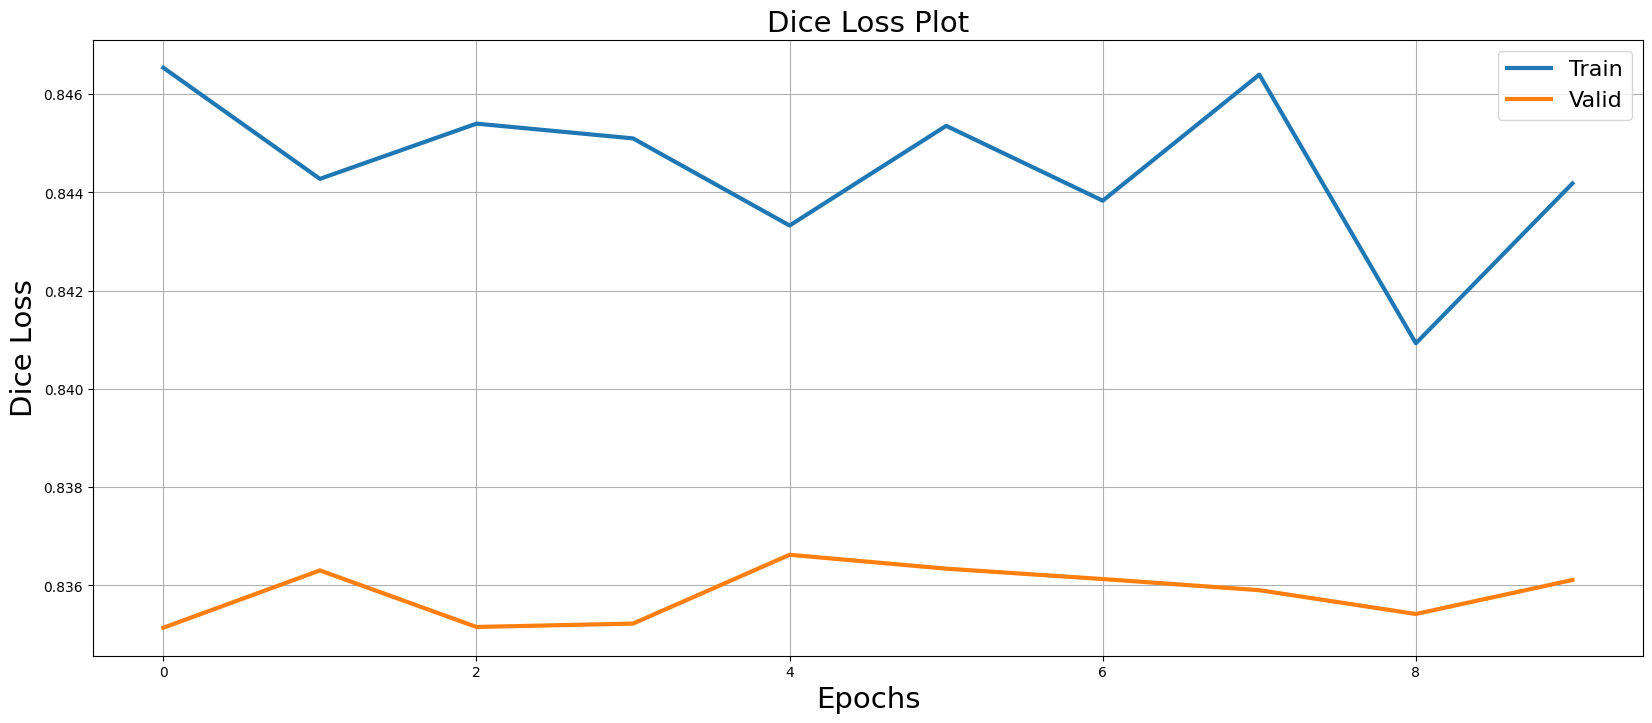

In [26]:
import matplotlib.pyplot as plt

# Extract the second row (third row including header) as x-axis values
x_values = range(len(train_logs_df.columns))

# Assuming 'iou_score' is the column name
plt.figure(figsize=(20, 8))
plt.plot(x_values, train_logs_df.iloc[0], lw=3, label='Train')  
plt.plot(x_values, valid_logs_df.iloc[0], lw=3, label='Valid')  
plt.xlabel('Epochs', fontsize=21)
plt.ylabel('Dice Loss', fontsize=21)
plt.title('Dice Loss Plot', fontsize=21)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()

<a name='6.0'></a>

#### 6.0 CONCLUSION AND RECOMMENDATION

Looking at both the prediction masks and the plots of both the loss and score, it seems like the model is learning the images, but can't seem to generalize on classes that are underrepresented, there's also issues with mislabeled classes. Take a look at a couple examples of the original image, ground truth mask, and prediction mask below:

<figure>
    <center> <img src="./sample_predictions/sample_pred_1.png"   style="width:850px;height:400px;" ></center>
</figure>

<figure>
    <center> <img src="./sample_predictions/sample_pred_3.png"   style="width:850px;height:400px;" ></center>
</figure>

In both images, skirts are masked as dresses. Correctly labeled and consistent labeling for a dataset is crucial for a model to learn from the dataset.

To further improve the model, I would recommend the following:
* Increase the dataset on under-represented class categories.
* Apart from focusing representation per item, also focus on increasing datasets based on the total number of pixels as well.
* Go through all the images to make sure that every masked images are consistently labeled with the correct label.
* If the particular class category is under-represented and it's difficult to obtain more datasets that contain that particular class category and it can be combined with another class category (for example, if wedges is only showing in 2 images, and it's difficult to obtain more datasets on said class, and it's not absolutely necessary for the project, consider letting go of the wedges category and mask them as shoes instead, in which case, it will still be correctly labeled, as wedges are considered to be a sub-category of shoes)
* Based on what the model have been able to successfully learn, such as hair, skin, dress, and pants, set that as the minimum threshold for 'the number of pixels the dataset need for each category'.